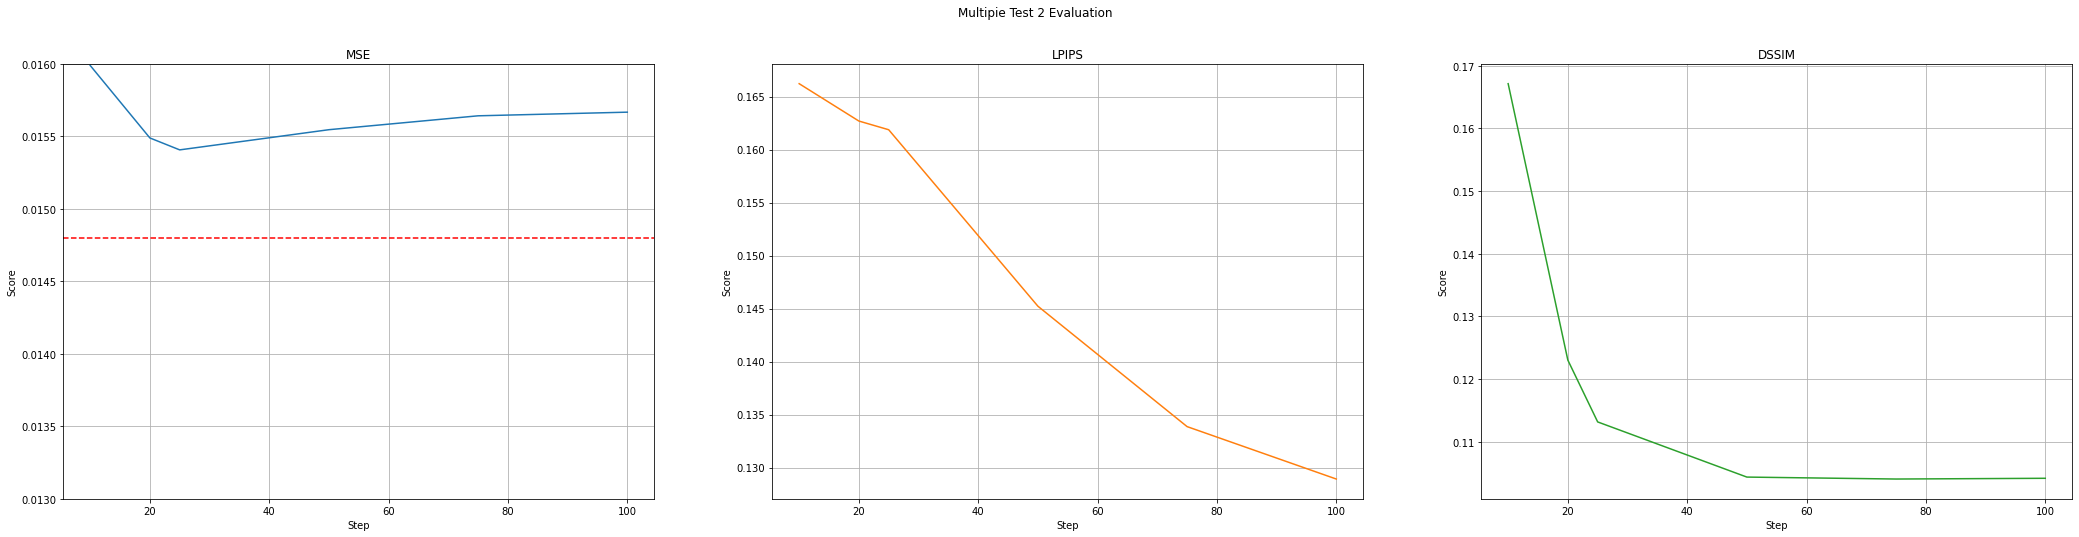

In [33]:
import numpy as np
import json, glob, os
import matplotlib.pyplot as plt

path = '/data/mint/TPAMI_evaluations/MP/score/ours_difareli++_with_solver/multipie/mp_test2/'
depth_scale = 100.0

score_dict = {'dpmsolver++': {}}
for p in glob.glob(path + '*.json'):
    if str(depth_scale) in p:
        solver_cfg = p.split('/')[-1].split('.json')[0]
        _, _, solver_name, solver_method, solver_step, solver_order, _, solver_depth_scale = solver_cfg.split('_')
        score_dict[solver_name][int(solver_step)] = {}
        # print(solver_name, solver_method, solver_step, solver_order, solver_depth_scale)
        with open(p, 'r') as f:
            data = json.load(f)
            for score in ['dssim', 'mse', 'lpips']:
                # print(data['eval_score'][score].split('+-'))
                mean, sd = data['eval_score'][score].split('+-')
                mean = float(mean)
                sd = float(sd)
                score_dict[solver_name][int(solver_step)][score] = {'mean': mean, 'sd': sd}
                
mse = []
lpips = []
dssim = []
steps = []
for solver in score_dict.keys():
    for step in sorted(score_dict[solver].keys()):
        steps.append(step)
        mse.append(score_dict[solver][step]['mse']['mean'])
        lpips.append(score_dict[solver][step]['lpips']['mean'])
        dssim.append(score_dict[solver][step]['dssim']['mean'])
# Create 3x1 sub plots
fig, axs = plt.subplots(1, 3, figsize=(36, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Multipie Test 2 Evaluation')
axs[0].plot(steps, mse, 'tab:blue')
axs[0].set_title('MSE')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Score')
axs[0].axhline(y=0.0148, color='r', linestyle='--')
axs[0].axhline(y=0.0169, color='magenta', linestyle='-')
axs[0].grid()
axs[0].set_ylim([0.013, 0.016])
axs[1].plot(steps, lpips, 'tab:orange')
axs[1].set_title('LPIPS')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Score')
axs[1].grid()
axs[2].plot(steps, dssim, 'tab:green')
axs[2].set_title('DSSIM')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Score')
axs[2].grid()
plt.show()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def plot_seaborn(score_dict, ours_test_score, test_on, metric, solver_name, solver_label, marker=['o', 's', 'D']):
    # Your data
    plot_step = [10, 25, 50, 75, 100]
    plt.figure(figsize=(14, 12))
    plt.rcParams['font.family'] = 'Calibri'
    sns.set_theme(style="whitegrid")  # Set the theme for Seaborn
    sns.set_context("talk")  # Adjusts the size of the labels, lines, and other elements of the plot# Adjusting text elements
    
    linewidth = 4
    markersize = 13
    fontsize = 30
    tick_fontsize = 30
    

    for i, sn in enumerate(solver_name):
        x = []
        y = []
        for steps in plot_step:
            error = score_dict[sn]['steps'][str(steps)]
            x.append(int(steps))
            y.append(float(error[f'mean_{metric}']))

        sns.lineplot(x=x, y=y, marker=marker[i], linestyle='-', label=solver_label[i], linewidth=linewidth, markersize=markersize)

    # Add titles and labels
    # plt.title(f'{str.upper(metric)} vs. Diffusion steps', fontsize=35)
    plt.xlabel('Diffusion steps (Runtime in sec)', fontsize=fontsize, labelpad=10)
    plt.ylabel(f'{str.upper(metric)}↓', fontsize=fontsize, labelpad=10)
    plt.xticks(fontsize=tick_fontsize)  # Adjust X-axis tick label size
    plt.yticks(fontsize=tick_fontsize)  # Adjust Y-axis tick label size

    plt.tick_params(axis='x', which='major', pad=-5)  # Increase pad for x-axis
    plt.tick_params(axis='y', which='major', pad=-5)  # Increase pad for y-axis
    if metric == 'dssim':
        current_yticks_values, current_yticks_labels = plt.yticks()
        plt.ylim(bottom=current_yticks_values[0] - 0.001)
    
    # current_yticks_values = list(np.array(current_yticks_values) + 0.001)  # Adjust Y-axis tick values
    # plt.yticks(current_yticks_values, [f"{y:.4f}" for y in current_yticks_values])  # Adjust Y-axis tick labels


    runtime_list = [f"{time['mean_runtime']:.2f}" for step, time in runtime_dict.items()]
    print(runtime_list)
    plt.xticks(x, [f"{x_val}\n(~{rt})" for x_val, rt in zip(x, runtime_list)])  # Adjust runtime text here
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust `nbins` for y-axis ticks
    

    # Adding DiFaReli's baseline
    plt.axhline(y=ours_test_score['difareli++'][f'mean_{metric}'], color='magenta', linestyle='--', label='DiFaReli (1000 steps)', linewidth=3, alpha=0.9)
    if metric == 'lpips':
        plt.text(80, ours_test_score['difareli++'][f'mean_{metric}'], '~194.26 sec', 
            ha='left', va='bottom', color='magenta', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.2'))
    else: 
        plt.text(6.5, ours_test_score['difareli++'][f'mean_{metric}'], '~194.26 sec', 
            ha='left', va='bottom', color='magenta', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.2'))
        
    # plt.text(6, ours_test_score['difareli'][f'mean_{metric}'], '~194.26 sec', ha='left', va='bottom', color='magenta', fontsize=28)
    # plt.text(80, ours_test_score['difareli'][f'mean_{metric}'], '~194.26 sec', ha='left', va='bottom', color='magenta', fontsize=28)

    # Adding single shot (assuming `ours_test_score` is defined outside this function)
    plt.axhline(y=ours_test_score['ss'][f'mean_{metric}'], color='red', linestyle='--', label='DiFaReli$_{\\mathbf{ss}}$ (1 step)', linewidth=linewidth, alpha=0.9)
    # plt.text(6.5, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', ha='left', va='bottom', color='red', fontsize=tick_fontsize)
    
    if metric == 'lpips':
        plt.text(80, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', 
            ha='left', va='bottom', color='red', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.2'))
    else: 
        plt.text(6.5, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', 
            ha='left', va='bottom', color='red', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.2'))
    # plt.text(80, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', ha='left', va='bottom', color='red', fontsize=tick_fontsize)

    leg = plt.legend(fontsize=34)  # Adjust legend font size
    for text in leg.get_texts():
        if text.get_text() == 'DiFaReli$_{\\mathbf{ss}}$ (1 step)':
            # text.set_color('red')
            text.set_fontweight('bold')
    
    os.makedirs('./roc_curve', exist_ok=True)
    plt.savefig(f'./roc_curve/{test_on}_{metric}.png', bbox_inches='tight', dpi=300)
    plt.show()
    

In [23]:
import numpy as np
import json, glob, os
import matplotlib.pyplot as plt

test_on = 'mp_test'
path = f'/data/mint/TPAMI_evaluations/MP/score/ours_difareli++_with_solver/multipie/{test_on}/'
runtime_path = f'/data/mint/TPAMI_evaluations/MP/pred/Ours/ours_difareli++_with_solver/ema_085000/{test_on}/'
depth_scale = 100.0

score_dict = {'dpmsolver++': {'steps':{}}, 'dpmsolver': {'steps':{}}, 'unipc': {'steps':{}}}
for p in glob.glob(path + '*.json'):
    if str(depth_scale) in p:
        solver_cfg = p.split('/')[-1].split('.json')[0]
        _, _, solver_name, solver_method, solver_step, solver_order, _, solver_depth_scale = solver_cfg.split('_')
        # score_dict[solver_name]['steps'][int(solver_step)] = {}
        score_dict[solver_name]['steps'][solver_step] = {}
        # print(solver_name, solver_method, solver_step, solver_order, solver_depth_scale)
        with open(p, 'r') as f:
            data = json.load(f)
            for metric in ['dssim', 'mse', 'lpips']:
                # print(data['eval_score'][score].split('+-'))
                mean, sd = data['eval_score'][metric].split('+-')
                mean = float(mean)
                sd = float(sd)
                score_dict[solver_name]['steps'][solver_step][f'mean_{metric}'] = mean
                score_dict[solver_name]['steps'][solver_step][f'sd_{metric}'] = sd
            runtime_file = glob.glob(f"{runtime_path}/{solver_cfg.split('eval_score_')[-1]}/runtime*")
            # print(runtime_file, f'{runtime_path}/{solver_cfg}')
            with open(runtime_file[0], 'r') as f:
                runtime = json.load(f)
            score_dict[solver_name]['steps'][str(solver_step)]['mean_runtime'] = np.mean(np.array(runtime['rev_time']) + np.array(runtime['relit_time']))
            score_dict[solver_name]['steps'][str(solver_step)]['sd_runtime'] = np.std(np.array(runtime['rev_time']) + np.array(runtime['relit_time']))
                

runtime_dict = {}
plot_step = ['10', '25', '50', '75', '100']
for step in plot_step:
    tmp = []
    for solver in score_dict.keys():
        tmp.append(score_dict[solver]['steps'][str(step)]['mean_runtime'])
        # print(solver, step, score_dict[solver]['steps'][str(step)]['mean_runtime'])
    runtime_dict[step] = {'mean_runtime':np.mean(tmp), 'sd_runtime':(np.mean(tmp))}
# print(runtime_dict)

ours_single_shot = {
    'mean_mse': 0.0075,
    'sd_mse': 0.0077,
    'mean_lpips': 0.1023,
    'sd_lpips': 0.0367,
    'mean_dssim': 0.0590,
    'sd_dssim': 0.0272,
}

ours_ddim_1000ts = {
    'mean_mse': 0.0090,
    'sd_mse': 0.0095,
    'mean_lpips': 0.1043,
    'sd_lpips': 0.0396,
    'mean_dssim': 0.0604,
    'sd_dssim': 0.0296,
}

ours_test_score = {'difareli++':ours_ddim_1000ts, 'ss':ours_single_shot}

plot_seaborn(score_dict, ours_test_score, test_on, 'mse', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])
plot_seaborn(score_dict, ours_test_score, test_on, 'dssim', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])
plot_seaborn(score_dict, ours_test_score, test_on, 'lpips', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])

{'dpmsolver++': {'steps': {'100': {'mean_dssim': 0.08439607918262482, 'sd_dssim': 0.02944377064704895, 'mean_mse': 0.008267857134342194, 'sd_mse': 0.008509056642651558, 'mean_lpips': 0.10909414291381836, 'sd_lpips': 0.039211854338645935, 'mean_runtime': 12.939281729700394, 'sd_runtime': 0.13820046512727743}, '25': {'mean_dssim': 0.09446421265602112, 'sd_dssim': 0.02875002659857273, 'mean_mse': 0.00806630402803421, 'sd_mse': 0.008125961758196354, 'mean_lpips': 0.1505301594734192, 'sd_lpips': 0.0385686419904232, 'mean_runtime': 3.1776836204694763, 'sd_runtime': 0.04485156436967267}, '20': {'mean_dssim': 0.10469473898410797, 'sd_dssim': 0.029115475714206696, 'mean_mse': 0.008118661120533943, 'sd_mse': 0.008112773299217224, 'mean_lpips': 0.1495160609483719, 'sd_lpips': 0.039141517132520676, 'mean_runtime': 2.5492559589808614, 'sd_runtime': 0.0425206462383536}, '50': {'mean_dssim': 0.08479131758213043, 'sd_dssim': 0.029058491811156273, 'mean_mse': 0.008179310709238052, 'sd_mse': 0.008369974